## Predicting Bike Rentals
The dataset for this project is obtained from University of California, Irvine website. It has data about number of bikes rented for each hour and number of other possible relevent features. The goal of the project is to predict number of bikes people will rent in any given hour

In [1]:
#Importing relevant libraries and reading source data
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
bike_rentals=pd.read_csv('data/bike_rental_hour.csv')
bike_rentals.head(5)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


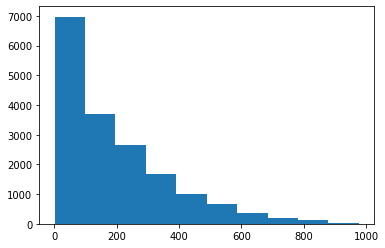

In [2]:
plt.hist(bike_rentals['cnt'])
plt.show()

In [3]:
correlations=bike_rentals.corr()['cnt'].abs().sort_values()
correlations

weekday       0.026900
workingday    0.030284
holiday       0.030927
windspeed     0.093234
mnth          0.120638
weathersit    0.142426
season        0.178056
yr            0.250495
instant       0.278379
hum           0.322911
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [4]:
#creating new feature for hour window based on hour value
def assign_label (hr):
    hr_window=1
    if hr>=6 and hr <12:
        hr_window=1
    elif hr>=12 and hr<18:
        hr_window=2
    elif hr>=18 and hr<24:
        hr_window=3
    elif hr>=0 and hr<6:
        hr_window=4
    return hr_window

bike_rentals['time_label']=bike_rentals.apply(lambda x:assign_label(x['hr']),axis=1)
bike_rentals['time_label'].value_counts()

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64

In [5]:
train_cutoff=.8*len(bike_rentals)

In [6]:
#reordering dataframe randomly and dividing into training and test dataset
train=bike_rentals.sample(frac=.8,random_state=1)
test=bike_rentals.loc[~bike_rentals.index.isin(train.index)]
print(len(train))
print(len(test))

13903
3476


In [7]:
#creating a linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
#predictor columns are picked based on correlation matrix and variables 
#which I think will have an impact on number of bikes rented
predictors = list(train.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")

lm = LinearRegression()
lm.fit(train[predictors],train['cnt'])
prediction=lm.predict(test[predictors])
mse=mean_squared_error(test['cnt'],prediction)
rmse=np.sqrt(mse)
print("MSE for this is {:.2f}".format(mse))
print("RMSE for this is {:.2f}".format(rmse))

error = np.mean((prediction - test["cnt"]) ** 2)
print("Error for this is {:.2f}".format(error))

MSE for this is 17052.12
RMSE for this is 130.58
Error for this is 17052.12


Initially used a basic linear regression model and we got a rmse of 130.58 and error of 17052.12 which is not that great. It indicates a high error rate in our prediction

In [8]:
#creating a basic decision tree model as linear regression does not give
#a very good model
from sklearn.tree import DecisionTreeRegressor
#from sklearn.metrics import roc_auc_score

dm = DecisionTreeRegressor(min_samples_leaf=5)
dm.fit(train[predictors],train['cnt'])
prediction_on_train=dm.predict(train[predictors])
prediction=dm.predict(test[predictors])
error_train=np.mean((prediction_on_train - train["cnt"]) ** 2)
error=np.mean((prediction - test["cnt"]) ** 2)

#auc = roc_auc_score(test['cnt'],prediction)
print("Error for this model on training dataset is {:.2f}".format(error_train))
print("Error for this model on test dataset is {:.2f}".format(error))


Error for this model on training dataset is 1002.27
Error for this model on test dataset is 2737.48


The error rate improved a lot compared to linear regression but it looks like the model is overfitting the data a lot based on training data. Since the difference between error rate on training and test data is significant it indicates that the model has an overfitting problem

In [9]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(min_samples_leaf=5, min_samples_split=2, n_estimators=10)
rf.fit(train[predictors],train['cnt'])
prediction_on_train=rf.predict(train[predictors])
prediction=rf.predict(test[predictors])
error_train=np.mean((prediction_on_train - train["cnt"]) ** 2)
error=np.mean((prediction - test["cnt"]) ** 2)

#auc = roc_auc_score(test['cnt'],prediction)
print("Error for this model on training dataset is {:.2f}".format(error_train))
print("Error for this model on test dataset is {:.2f}".format(error))

Error for this model on training dataset is 1027.98
Error for this model on test dataset is 2137.70


By using a random forest regressor model the error rate was reduced further and also the model is less prone to overfitting.